In [1]:
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

"""To display up to 50 columns of dataset"""
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 8)

"""To display all outputs of each cell"""
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


np.random.seed(100)


"""To get a timing of each function decorated"""
def timing(f):
    """
    Decorator for timing functions
    Usage:
    @timing
    def function(&):
        pass
    """
    
    
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('function:%r took: %2.2f sec' % (f.__name__, end - start))
        return result
    return wrapper


Bad key "“backend" on line 1 in
/Users/rfdanti/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1

In [2]:
class Trainer():
    """Base processor to be used for all preparation"""""
    def __init__(self, input_directory, df_): #input_directory = path to the folder containing df. 
        self.input_directory = input_directory
        self.df = df_
        
        
    @timing
    def read(self):
        """Read raw data"""
        self.df = pd.read_csv(self.input_directory + self.df)
       
        
    @timing
    def preprocessing(self):
        """processing of the input data"""
            
        #type change to category where needed
        self.category_columns = ["Store", "StoreType", "Assortment", "DayOfWeek", "PromoInterval", "StateHoliday",
                                 "OpeningType", "Month", "WeekOfYear", "DateOfMonth", "AffectedByCompetition", 
                                 "AffectedByPromo2", "StateHoliday", "SchoolHoliday", "Promo", "Promo2"]
        
        for column in self.category_columns:
            self.df[column] = self.df[column].astype('category')
            
        self.binary_columns = ["AffectedByCompetition", "AffectedByPromo2", "SchoolHoliday", "Promo", "Promo2"]
     
        for column in self.binary_columns:
            self.df[column] = self.df[column].astype('bool')
            
        #self.df = pd.get_dummies(self.df, columns=["StoreType", "Assortment", "DayOfWeek", "PromoInterval", 
                                                   #"StateHoliday", "OpeningType", "Month", "WeekOfYear", 
                                                   #"DateOfMonth", "StateHoliday"])
            
        #extract only data of open stores
        self.df_open = self.df[self.df["Open"] == 1]
        self.df = self.df_open
        
        #Re_indexation 
        self.df = self.df.reset_index(drop='True')
        
        """put the date as index"""
        self.df["Date"] = pd.to_datetime(self.df["Date"].astype(str), format = '%Y/%m/%d')
        self.df = self.df.set_index("Date")
            
            
        self.df = self.df.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", 
                                "Promo2SinceWeek", "Promo2SinceYear", "Promo2SinceDate", "CompetitionOpenSinceDate",
                               "Customers", "Open"], axis = 1)
               
        self.train_df = self.df["2013-01-01": "2015-06-13"]
        self.test_df = self.df["2015-06-14":]
             
        self.y_train, self.y_test = self.train_df[['Sales']], self.test_df[["Sales"]]
        
        self.X_train = self.train_df.drop(["Sales"], axis = 1)
        self.X_test = self.test_df.drop(["Sales"], axis = 1)
        
        self.X_train_random, self.X_test_random, self.y_train_random, self.y_test_random = train_test_split(self.df.drop(["Sales"], axis = 1), self.df[['Sales']], test_size=0.2)
        
        
    @timing
    def model_fit(self):
        self.params = {'n_estimators':1000, 'max_depth':3,'learning_rate':1 ,'criterion':'mse'}
        self.model_gb = GradientBoostingRegressor(**self.params)
        self.model_gb.fit(self.X_train, self.y_train)
        
        
    @timing
    def model_fit_random(self):
        self.params = {'n_estimators':1000, 'max_depth':3,'learning_rate':1 ,'criterion':'mse'}
        self.model_random_gb = GradientBoostingRegressor(**self.params)
        self.model_random_gb.fit(self.X_train_random, self.y_train_random)
        
        
    @timing
    def validation(self, nb_store):
        self.predicted = self.model_gb.predict(self.X_test[self.X_test["Store"] == nb_store])
        self.predicted = self.predicted.reshape(-1, 1)
        #self.predicted = self.standardize.inverse_transform(self.predicted)
        #self.predicted = np.square(self.predicted)
        
        
        plt.figure(figsize=(18, 7), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(self.y_test[self.X_test["Store"] == nb_store].index, self.predicted, color = 'blue',label = 'Predicted values')
        plt.plot(self.y_test[self.X_test["Store"] == nb_store], color = 'red', label = 'Real values')
        plt.legend()
        
        self.errors = abs(self.predicted - self.y_test[self.X_test["Store"] == nb_store])
        print('Mean Absolute Error:', round(np.mean(self.errors), 2))
        print('RMSE', round(m.sqrt(mean_squared_error(self.predicted, self.y_test[self.X_test["Store"] == nb_store])), 2))
    
    @timing
    def rmse(self):
        self.predicted = self.model_gb.predict(self.X_test)
        self.predicted = self.predicted.reshape(-1, 1)
        #self.predicted = self.standardize.inverse_transform(self.predicted)
        #self.predicted = np.square(self.predicted)

        self.errors = abs(self.predicted - self.y_test)
        print('Mean Absolute Error:', round(np.mean(self.errors), 2))
        print('RMSE', round(m.sqrt(mean_squared_error(self.predicted, self.y_test)), 2))
        
    @timing
    def rmse_random(self):
        self.predicted_ran = self.model_random_gb.predict(self.X_test_random)
        self.predicted_ran = self.predicted_ran.reshape(-1, 1)
        #self.predicted_ran = self.standardize.inverse_transform(self.predicted_ran)
        #self.predicted_ran = np.square(self.predicted_ran)

        self.errors_ran = abs(self.predicted_ran - self.y_test_random)
        print('Mean Absolute Error:', round(np.mean(self.errors_ran), 2))
        print('RMSE', round(m.sqrt(mean_squared_error(self.predicted_ran, self.y_test_random)), 2))
        
        
    def save_result(self, nb_store):
        self.result = self.y_test[self.X_test["Store"] == nb_store]
        self.predicted_store = self.model_gb.predict(self.X_test[self.X_test["Store"] == nb_store])
        self.error_store = abs(self.predicted_store.reshape(-1, 1) - self.y_test[self.X_test["Store"] == nb_store])

        self.result["predicted_RF"] = self.predicted_store
        self.result["error_RF"] = self.error_store
        
        return self.result
        
    

In [3]:
project = Trainer("/Users/rfdanti/Documents/UoM/2_data_analytics/coursework/CODE/", "full_trainset_v2.csv")
project.read()
project.preprocessing()

function:'read' took: 2.24 sec
function:'preprocessing' took: 2.34 sec


In [39]:
project.model_fit()

/Users/rfdanti/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


function:'model_fit' took: 963.72 sec


In [40]:
project.rmse()

Mean Absolute Error: Sales    829.25
dtype: float64
RMSE 1147.47
function:'rmse' took: 0.41 sec


In [21]:
result_471 = project.save_result(471)
result_471 = result_471.reset_index(drop=False)
result_471.to_csv("GradientBoost_store471_6weeks.csv", index=False)

result_345 = project.save_result(345)
result_345 = result_345.reset_index(drop=False)
result_345.to_csv("GradientBoost_store345_6weeks.csv", index=False)

result_133 = project.save_result(133)
result_133 = result_133.reset_index(drop=False)
result_133.to_csv("GradientBoost_store133_6weeks.csv", index=False)

result_55 = project.save_result(55)
result_55 = result_55.reset_index(drop=False)
result_55.to_csv("GradientBoost_store55_6weeks.csv", index=False)

result_1000 = project.save_result(1000)
result_1000 = result_1000.reset_index(drop=False)
result_1000.to_csv("GradientBoost_store1000_6weeks.csv", index=False)

result_849 = project.save_result(849)
result_849 = result_849.reset_index(drop=False)
result_849.to_csv("GradientBoost_store849_6weeks.csv", index=False)

result_802 = project.save_result(802)
result_802 = result_802.reset_index(drop=False)
result_802.to_csv("GradientBoost_store802_6weeks.csv", index=False)

result_1000.head()

/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Date,Sales,predicted_RF,error_RF
0,2015-06-15,7436,10410.146484,2974.146484
1,2015-06-16,9485,8915.367271,569.632729
2,2015-06-17,8655,9178.774597,523.774597
3,2015-06-18,6711,8011.887390,1300.887390
4,2015-06-19,9355,8476.785969,878.214031


In [22]:
result_733 = project.save_result(733)
result_733 = result_733.reset_index(drop=False)
result_733.head()

/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Sales,predicted_RF,error_RF
0,2015-06-14,16452,15844.587983,607.412017
1,2015-06-15,16710,15960.542598,749.457402
2,2015-06-16,16007,15888.025811,118.974189
3,2015-06-17,15036,16572.450948,1536.450948
4,2015-06-18,15269,15431.516103,162.516103


In [23]:
result_733.to_csv("GradientBoost_store733_6weeks.csv", index=False)

In [24]:
result_351 = project.save_result(351)
result_351 = result_351.reset_index(drop=False)
result_351.head()

/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Sales,predicted_RF,error_RF
0,2015-06-15,9850,8374.054512,1475.945488
1,2015-06-16,7449,7005.892289,443.107711
2,2015-06-17,6829,7343.487889,514.487889
3,2015-06-18,6628,6118.033097,509.966903
4,2015-06-19,6716,6579.217903,136.782097


In [25]:
result_351.to_csv("GradientBoost_store351_6weeks.csv", index=False)

In [26]:
result_279 = project.save_result(279)
result_279 = result_279.reset_index(drop=False)
result_279.head()

/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rfdanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Sales,predicted_RF,error_RF
0,2015-06-15,19655,11171.785964,8483.214036
1,2015-06-16,11692,9502.846491,2189.153509
2,2015-06-17,12551,9940.414077,2610.585923
3,2015-06-18,10696,8773.526870,1922.473130
4,2015-06-19,10873,9894.886213,978.113787


In [27]:
result_279.to_csv("GradientBoost_store279_6weeks.csv", index=False)

In [4]:
project.model_fit_random()

/Users/rfdanti/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


function:'model_fit_random' took: 1001.09 sec


In [5]:
project.rmse_random()

Mean Absolute Error: Sales    711.78
dtype: float64
RMSE 997.28
function:'rmse_random' took: 2.58 sec


/Users/rfdanti/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Mean Absolute Error: Sales    636.61
dtype: float64
RMSE 849.84
function:'validation' took: 0.29 sec


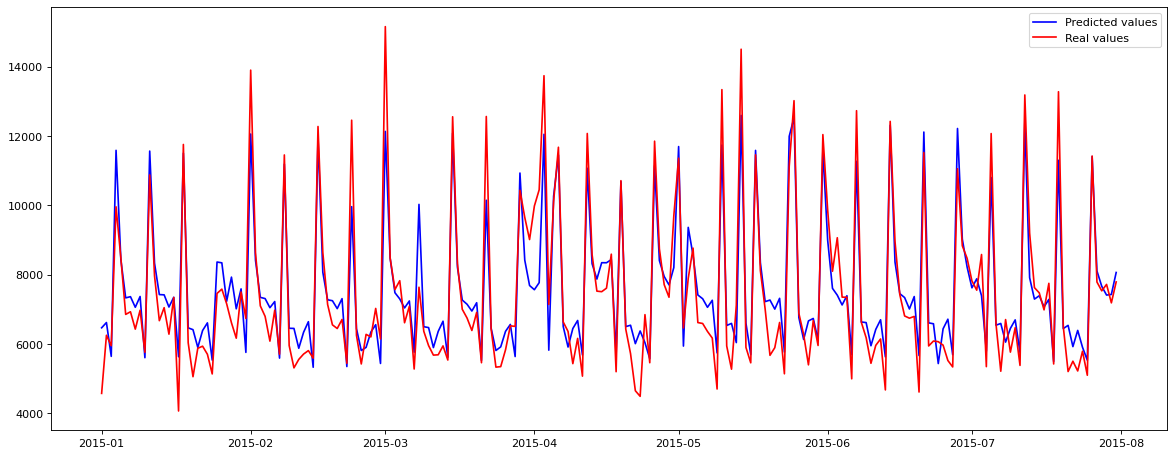

In [21]:
project.validation(85)
#85 randomly selected as the store used to check the prediction

#standardized + square root

<Figure size 1440x560 with 0 Axes>

Mean Absolute Error: Sales    722.96
dtype: float64
RMSE 982.43


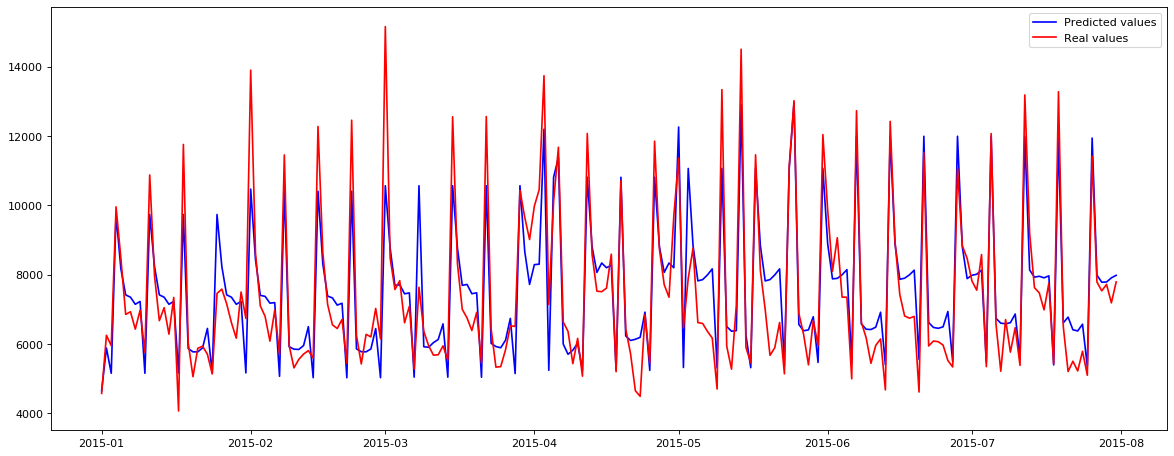

In [41]:
#standardized + square root
project.predicted = project.model.predict(project.X_test[project.X_test["Store"] == 85])
project.predicted = project.predicted.reshape(-1, 1)
project.predicted = project.standardize.inverse_transform(project.predicted)
project.predicted = np.square(project.predicted)

plt.figure(figsize=(18, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(project.y_test[project.X_test["Store"] == 85].index, project.predicted, color = 'blue',label = 'Predicted values')
plt.plot(project.y_test[project.X_test["Store"] == 85], color = 'red', label = 'Real values')
plt.legend()

project.errors = abs(project.predicted - project.y_test[project.X_test["Store"] == 85])
print('Mean Absolute Error:', round(np.mean(project.errors), 2))
print('RMSE', round(m.sqrt(mean_squared_error(project.predicted, project.y_test[project.X_test["Store"] == 85])), 2))

In [27]:
#standardized + square root
predicted = project.model.predict(project.X_test)
predicted = predicted.reshape(-1, 1)
predicted = project.standardize.inverse_transform(predicted)
predicted = np.square(predicted)

errors = abs(predicted - project.y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('RMSE', round(m.sqrt(mean_squared_error(predicted, project.y_test))))

Mean Absolute Error: Sales    866.57
dtype: float64
RMSE 1300


In [1]:
# no modification, random split
predicted = project.model.predict(project.X_test)
predicted = predicted.reshape(-1, 1)

errors = abs(project.y_test.values - predicted.reshape(predicted.shape[0]))
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('RMSE', round(m.sqrt(mean_squared_error(predicted.reshape(predicted.shape[0]), project.y_test.values))))

NameError: name 'project' is not defined

In [ ]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');